In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [ ]:
df=pd.read_csv('/content/deliveries.csv')

In [ ]:
df

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NaN,NaN,NaN
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260915,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,5,SS Iyer,AK Markram,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260916,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,6,VR Iyer,AK Markram,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260917,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,1,VR Iyer,Shahbaz Ahmed,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260918,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,2,SS Iyer,Shahbaz Ahmed,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN


In [ ]:
df.tail()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
260915,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,5,SS Iyer,AK Markram,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260916,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,6,VR Iyer,AK Markram,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260917,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,1,VR Iyer,Shahbaz Ahmed,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260918,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,2,SS Iyer,Shahbaz Ahmed,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260919,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,3,VR Iyer,Shahbaz Ahmed,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN


# **Forecasting the bowler's performance**

In [ ]:
bowler_data = df[['match_id', 'bowler', 'is_wicket', 'total_runs']]
bowler_data

,match_id,bowler,is_wicket,total_runs
0,335982,P Kumar,0,1
1,335982,P Kumar,0,0
2,335982,P Kumar,0,1
3,335982,P Kumar,0,0
4,335982,P Kumar,0,0
...,...,...,...,...
260915,1426312,AK Markram,0,1
260916,1426312,AK Markram,0,1
260917,1426312,Shahbaz Ahmed,0,1
260918,1426312,Shahbaz Ahmed,0,1


In [ ]:
performance = bowler_data.groupby(['match_id', 'bowler']).agg(
    wickets=('is_wicket', 'sum'),  # Total wickets per match
    runs_conceded=('total_runs', 'sum')  # Total runs conceded per match
).reset_index()
performance

,match_id,bowler,wickets,runs_conceded
0,335982,AA Noffke,1,41
1,335982,AB Agarkar,3,25
2,335982,AB Dinda,2,9
3,335982,CL White,0,24
4,335982,I Sharma,1,13
...,...,...,...,...
12973,1426312,PJ Cummins,1,18
12974,1426312,SP Narine,1,20
12975,1426312,Shahbaz Ahmed,1,28
12976,1426312,T Natarajan,0,29


In [ ]:
# Aggregate performance metrics for each bowler across matches
bowler_summary = performance.groupby('bowler').agg(
    total_wickets=('wickets', 'sum'),
    total_runs_conceded=('runs_conceded', 'sum'),
    matches_played=('match_id', 'nunique')
).reset_index()

# Calculate additional metrics
bowler_summary['average_runs_conceded'] = bowler_summary['total_runs_conceded'] / bowler_summary['matches_played']
bowler_summary['wickets_per_match'] = bowler_summary['total_wickets'] / bowler_summary['matches_played']

# Sort bowlers by total wickets and select the top 10
top_bowlers = bowler_summary.sort_values(by='total_wickets', ascending=False).head(10)
top_bowlers

,bowler,total_wickets,total_runs_conceded,matches_played,average_runs_conceded,wickets_per_match
524,YS Chahal,213,4681,159,29.440252,1.339623
119,DJ Bravo,207,4436,158,28.075949,1.310127
348,PP Chawla,201,5179,191,27.115183,1.052356
446,SP Narine,200,4672,175,26.697143,1.142857
355,R Ashwin,198,5435,208,26.129808,0.951923
71,B Kumar,195,5051,176,28.698864,1.107955
438,SL Malinga,188,3486,122,28.573770,1.540984
8,A Mishra,183,4193,162,25.882716,1.129630
193,JJ Bumrah,182,3840,133,28.872180,1.368421
373,RA Jadeja,169,4917,211,23.303318,0.800948


In [ ]:
# Choose a bowler to analyze
top_bowler = 'YS Chahal'
bowler_timeseries = performance[performance['bowler'] == top_bowler].set_index('match_id')['wickets']
print(bowler_timeseries)
# Sort the series by match_id (to ensure chronological order)
bowler_timeseries = bowler_timeseries.sort_index()


match_id
598029     0
729281     1
729287     2
729299     1
729305     1
          ..
1426294    1
1426299    1
1426303    2
1426310    1
1426311    0
Name: wickets, Length: 159, dtype: int64


In [ ]:
model = ARIMA(performance['wickets'], order=(1, 1, 1))
model_fit = model.fit()

In [ ]:
forecast_steps = 5
forecast = model_fit.forecast(steps=forecast_steps)

In [ ]:
print("Forecasted Wickets for the Next 5 Matches:")
print(forecast)

Forecasted Wickets for the Next 5 Matches:
12978    1.016568
12979    1.016175
12980    1.016184
12981    1.016184
12982    1.016184
Name: predicted_mean, dtype: float64


In [ ]:
import matplotlib.pyplot as plt

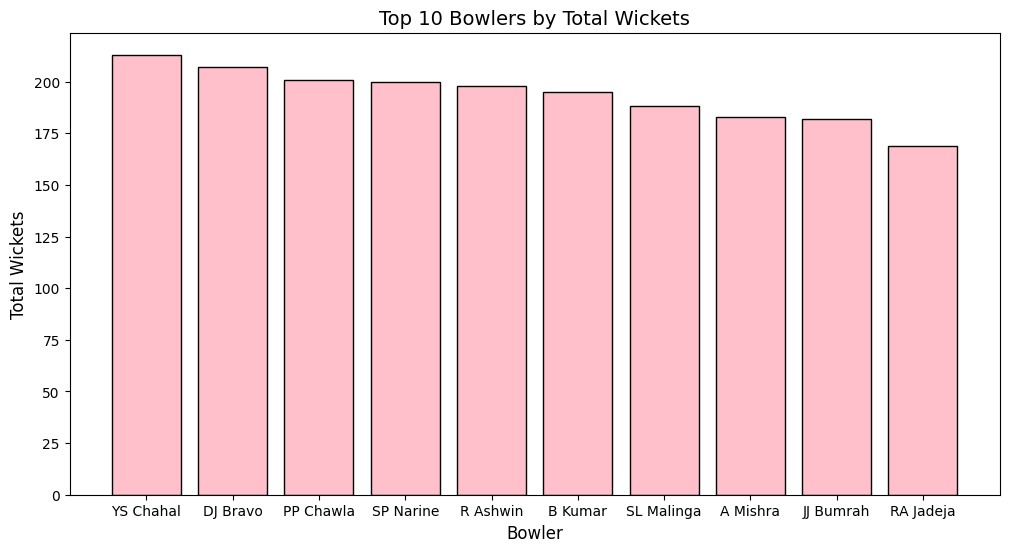

In [ ]:
#Barplot
plt.figure(figsize=(12, 6))

plt.bar(top_bowlers['bowler'], top_bowlers['total_wickets'], color='pink', edgecolor='black')

plt.title('Top 10 Bowlers by Total Wickets', fontsize=14)
plt.xlabel('Bowler', fontsize=12)
plt.ylabel('Total Wickets', fontsize=12)
plt.show()

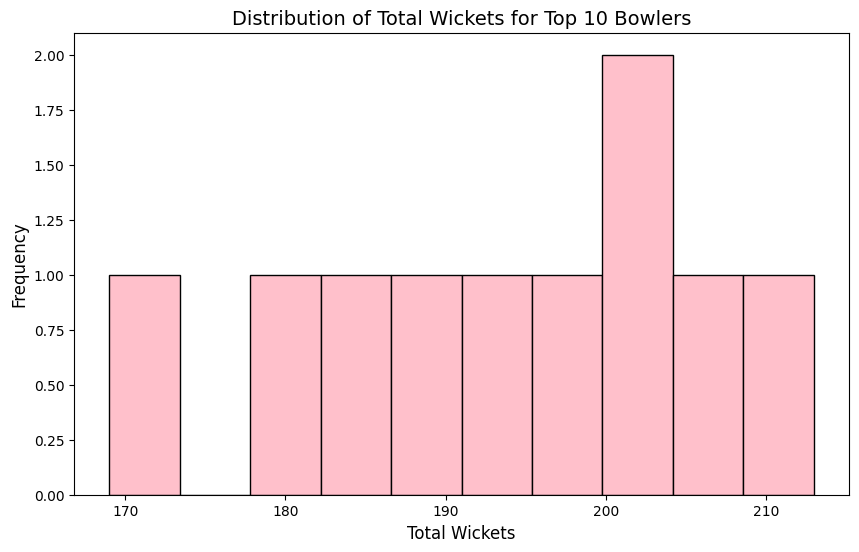

In [ ]:
#histogram
plt.figure(figsize=(10, 6))

plt.hist(top_bowlers['total_wickets'], bins=10, color='pink', edgecolor='black')

plt.title('Distribution of Total Wickets for Top 10 Bowlers', fontsize=14)
plt.xlabel('Total Wickets', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

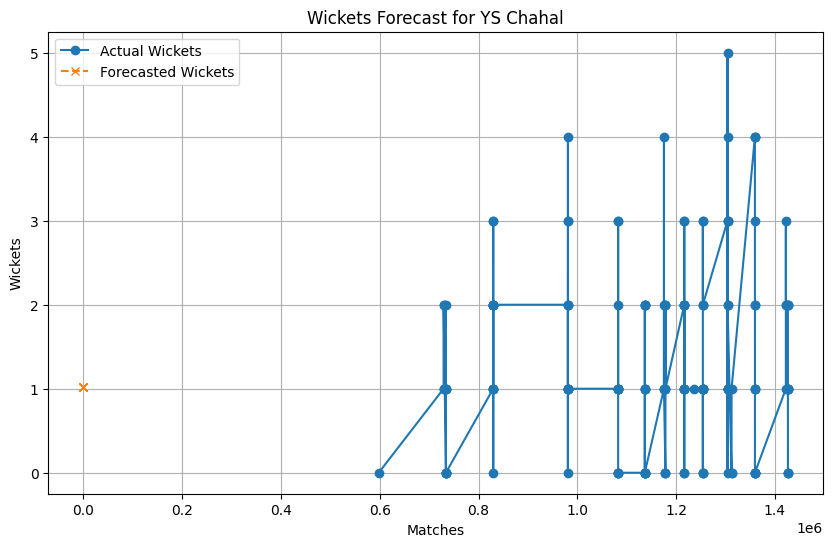

In [ ]:
#line plot
plt.figure(figsize=(10, 6))
plt.plot(bowler_timeseries, label='Actual Wickets', marker='o')
plt.plot(range(len(bowler_timeseries), len(bowler_timeseries) + forecast_steps), forecast, label='Forecasted Wickets', marker='x', linestyle='--')
plt.title(f'Wickets Forecast for {top_bowler}')
plt.xlabel('Matches')
plt.ylabel('Wickets')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Group by bowler to calculate total runs conceded and total balls bowled
bowler_stats = df.groupby('bowler').agg(
    total_runs_conceded=pd.NamedAgg(column='total_runs', aggfunc='sum'),
    total_balls_bowled=pd.NamedAgg(column='ball', aggfunc='sum')
).reset_index()

# Filter out bowlers who have bowled fewer than 100 balls
bowler_stats = bowler_stats[bowler_stats['total_balls_bowled'] >= 1000]

bowler_stats['economy_rate'] = bowler_stats['total_runs_conceded'] / (bowler_stats['total_balls_bowled'] / 6) #Economy rate
top_10_economy_bowlers = bowler_stats.sort_values(by='economy_rate').head(10) #Sort the bowlers by economy rate in ascending order
print(top_10_economy_bowlers)


               bowler  total_runs_conceded  total_balls_bowled  economy_rate
263    M Muralitharan                 1765                5720      1.851399
138          DW Steyn                 2583                8338      1.858719
7            A Kumble                 1089                3488      1.873280
147        GD McGrath                  366                1169      1.878529
181           J Yadav                  447                1422      1.886076
377  RE van der Merwe                  515                1635      1.889908
265       M Pathirana                  617                1948      1.900411
446         SP Narine                 4672               14728      1.903313
132         DP Nannes                  815                2569      1.903464
363         R Rampaul                  319                1005      1.904478


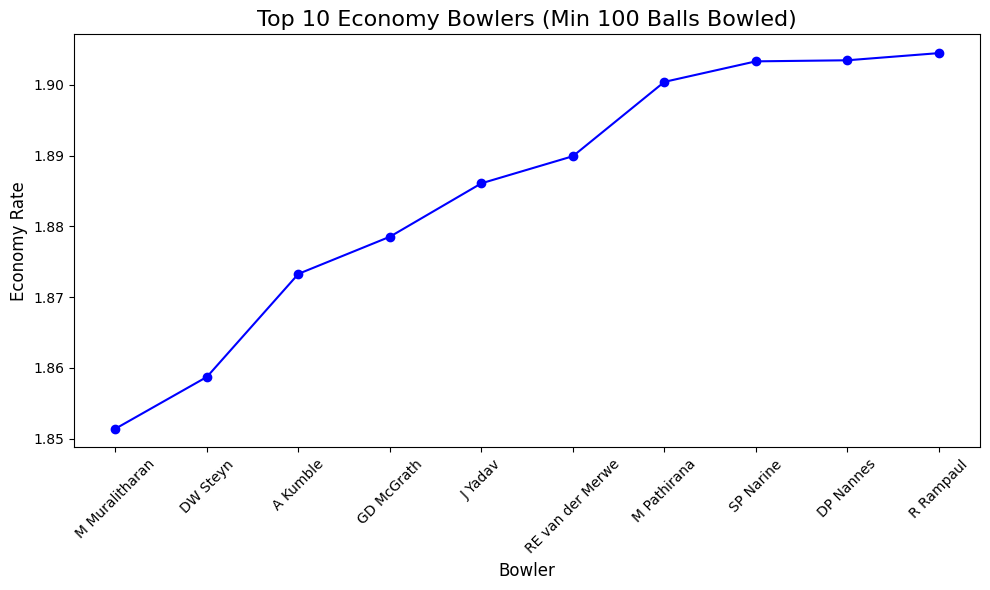

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(top_10_economy_bowlers['bowler'], top_10_economy_bowlers['economy_rate'], marker='o', linestyle='-', color='b')
plt.title('Top 10 Economy Bowlers (Min 100 Balls Bowled)', fontsize=16)
plt.xlabel('Bowler', fontsize=12)
plt.ylabel('Economy Rate', fontsize=12)
plt.xticks(rotation=45) #for better readability
plt.tight_layout()
plt.show()